In [ ]:
# ÉTAPE 1 : Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ÉTAPE 2 : Charger les données transformées
df = pd.read_csv("avito_pfm_transformed.csv")  # remplace par le bon nom du fichier
df_transformed = df.copy()
df_transformed.head()  # adapte si tu charges autrement

# ÉTAPE 3 : Séparer la variable cible et les variables explicatives
y = df_transformed['Prix']
X = df_transformed.drop('Prix', axis=1)

# ÉTAPE 4 : Définir les colonnes numériques et catégorielles
numerical_cols = ['kilometrage','NBporte','Puissance fiscale', 'Age']
categorical_cols = ['BoiteàV','Carburant', 'kilometrage', 'Origine','Première main', 'Etat','Limiteur de vitesse', 'Jantes aluminium', 
                    'CD/MP3/Bluetooth', 'Climatisation','Vitres électriques','Verrouillage centralisé à distance',
                    'Airbags', 'Caméra de recul', 'Système de navigation/GPS', 'Radar de recul', 'ESP', 'ABS', 'Ordinateur de bord', 
                    'Régulateur de vitesse', 'Sièges cuir', 'Toit ouvrant', 'Marque_freq', 'Modèle_freq' 
]

# ÉTAPE 5 : Créer le préprocesseur
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# ÉTAPE 6 : Créer un pipeline avec GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 4, 6],
    'model__learning_rate': [0.05, 0.1]
}

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
print("Meilleurs paramètres:", grid_search.best_params_)

# ÉTAPE 7 : Séparer les données pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ÉTAPE 8 : Réentraîner avec les meilleurs paramètres
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

# ÉTAPE 9 : Évaluation
train_r2 = best_pipeline.score(X_train, y_train)
test_r2 = best_pipeline.score(X_test, y_test)
y_pred = best_pipeline.predict(X_test)

print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

# ÉTAPE 10 : Validation croisée
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='r2')
print("Scores CV:", cv_scores)
print("Moyenne CV:", np.mean(cv_scores))

# ÉTAPE 11 : Sauvegarde du modèle
joblib.dump(best_pipeline, 'voiture_model_pipeline.pkl')
print("Modèle sauvegardé avec succès.")



Meilleurs paramètres: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Train R²: 0.89, Test R²: 0.61
MAE: 27.35
RMSE: 89.64
R² Score: 0.61
Scores CV: [0.8341225  0.88330786 0.77553118 0.59748636 0.9109057 ]
Moyenne CV: 0.8002707200812044
Modèle sauvegardé avec succès.


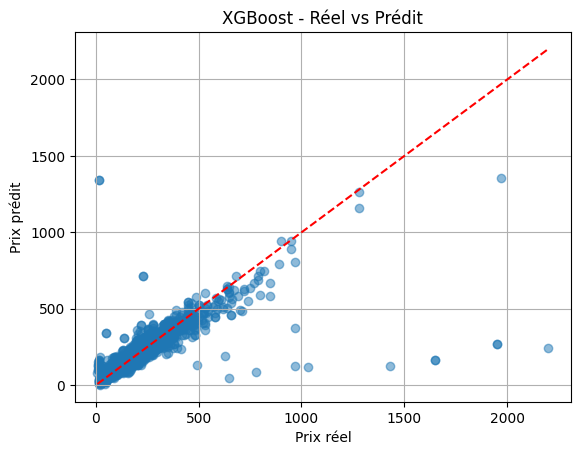

In [ ]:
# Graphique
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("XGBoost - Réel vs Prédit")
plt.grid(True)
plt.show()

In [ ]:
# Chargement du modèle
model = joblib.load("voiture_model_pipeline.pkl")

# Exemple de voiture
voiture = pd.DataFrame([{
    'BoiteàV': 1,
    'Carburant': 1,
    'kilometrage': -0.90,  # déstandard
    'NBporte': 5,
    'Origine': 1.0,         # même encodage que dataset
    'Première main': 1.0,
    'Puissance fiscale': -0.75,
    'Etat': 1.0,
    'Age': -0.60,
    'Limiteur de vitesse': 1,
    'Jantes aluminium': 0,
    'CD/MP3/Bluetooth': 1,
    'Climatisation': 1,
    'Vitres électriques': 1,
    'Verrouillage centralisé à distance': 0,
    'Airbags': 1,
    'Caméra de recul': 1,
    'Système de navigation/GPS': 1,
    'Radar de recul': 0,
    'ESP': 1,
    'ABS': 1,
    'Ordinateur de bord': 1,
    'Régulateur de vitesse': 1,
    'Sièges cuir': 0,
    'Toit ouvrant': 0,
    'Marque_freq': 0.09,
    'Modèle_freq': 0.01
}])

# Prédiction
prix_estime = model.predict(voiture)
print(f"💰 Prix estimé : {prix_estime[0]:.2f} K DH")


💰 Prix estimé : 159.58 K DH
